In [1]:
import pandas as pd
import random
from utils import *
from sentence_classifier import SentenceClassifier
from tokenizer_class import TokenizerClass
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from datasets import Dataset
from transformers import DataCollatorWithPadding
from evaluate import load
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jannis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/jannis/miniconda3/envs/mac-tens9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_articles=pd.read_csv('fulltext_wiki_protected.csv',sep=',')[['title','bytes','full_text']]
i=1
df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[0])
while i<len(all_articles):
    working_df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[i])
    df=pd.concat([df,working_df])
    i+=1


In [3]:
wiki_dataset = Dataset.from_pandas(df)

In [4]:
trans_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-german-cased')

In [5]:
def preprocess_transformer_token(example):
    return trans_tokenizer(example['text'], truncation=True)
    


In [6]:
tokenized_wiki = wiki_dataset.map(preprocess_transformer_token,batched=True)

100%|██████████| 462/462 [00:10<00:00, 43.95ba/s]


In [7]:
split_tokenized = tokenized_wiki.train_test_split(0.3)

In [8]:

data_collator = DataCollatorWithPadding(tokenizer=trans_tokenizer)

In [9]:

accuracy = load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
df_train=df.sample(50000,random_state=2)
tokenizer=TokenizerClass()
claim_extract=SentenceClassifier(tokenizer_class=tokenizer,)

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-german-cased", num_labels=2
)



Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', '

In [12]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_tokenized['train'],
    eval_dataset=split_tokenized['test'],
    tokenizer=trans_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


OSError: Looks like you do not have git-lfs installed, please install. You can install from https://git-lfs.github.com/. Then run `git lfs install` (you only have to do this once).

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(claim_extract.train_df) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model = keras.models.Sequential()
model.add(layers.Embedding(claim_extract.tokenizer_class.num_unique_words, 32, input_length=32))
# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.
model.add(layers.LSTM(256, dropout=0.1))
model.add(layers.Dense(1, activation="relu"))
#TODO try out others than sigmoid
#min 2nd layer or more
model.summary()
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]
model.compile(loss=loss, optimizer=optim, metrics=metrics)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 32)            3033728   
                                                                 
 lstm_4 (LSTM)               (None, 256)               295936    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,329,921
Trainable params: 3,329,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train=df.sample(50000,random_state=2)
tokenizer=TokenizerClass()
claim_extract=SentenceClassifier(tokenizer_class=tokenizer,model=model)
claim_extract.preprocess_train_val(df_train)
claim_extract.train_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 32)            3033728   
                                                                 
 lstm_4 (LSTM)               (None, 256)               295936    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,329,921
Trainable params: 3,329,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2023-02-13 16:51:07.295607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:51:07.612880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:51:07.924882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


668/668 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.5292

2023-02-13 16:51:32.177107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:51:32.261231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


668/668 [==============================] - 27s 38ms/step - loss: 0.7126 - accuracy: 0.5292 - val_loss: 0.6555 - val_accuracy: 0.6099
Epoch 2/20
668/668 [==============================] - 21s 31ms/step - loss: 0.6201 - accuracy: 0.6778 - val_loss: 0.7975 - val_accuracy: 0.5813
Epoch 3/20
668/668 [==============================] - 19s 29ms/step - loss: 0.4059 - accuracy: 0.8469 - val_loss: 1.0244 - val_accuracy: 0.6049
Epoch 3: early stopping


In [ ]:
annotated=pd.read_csv('FullAnnotated1.csv',sep=';',dtype={'sentence':'str'})
annotated=annotated[annotated['to_exclude']==0]
annotated['prediction']=claim_extract.predict_target(annotated['sentence'])

2023-02-13 16:52:18.782000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:52:18.848060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 58ms/step


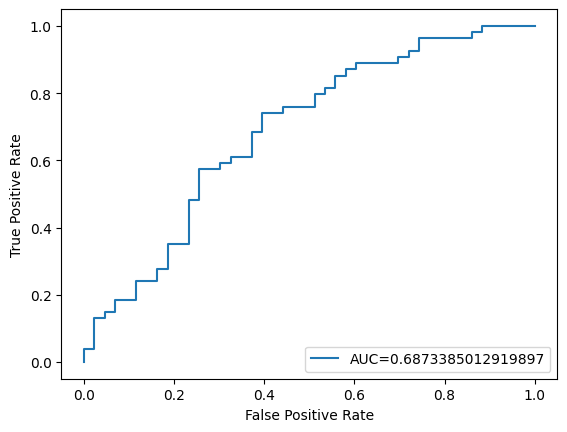

In [ ]:
a,b=plot_compute_AUC(annotated['is_claim'],  annotated['prediction'])

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(annotated['is_claim'],  annotated['prediction'])
auc = metrics.roc_auc_score(annotated['is_claim'],  annotated['prediction'])
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

AttributeError: 'bool' object has no attribute 'any'

In [ ]:
raise KeyboardInterrupt("Until autorun till here!")

KeyboardInterrupt: Until autorun till here!

In [ ]:
print(annotated)

     Unnamed: 0                                           sentence  is_claim  \
0             0  Ärger über Gasmasken-Eklat Samstag, 1 Juli, 12...         1   
1             1  Dabei hatte die Projektleitung eigentlich ein ...         0   
2             2  Trotz der beiden Bike-Lanes ist der Verkehr au...         1   
3             3  Interessant ist, dass es der Civey-Umfrage zuf...         1   
4             4  Die Salzburger Festspiele aber haben sich zumi...         0   
..          ...                                                ...       ...   
100         100  Auf manchen Friedhöfen gebe es eine überdachte...         0   
101         101  Sie schlagen mit ihren Gummiknüppeln auf die M...         1   
102         102  Anfang Mai wähnte sich die nationalpopulistisc...         1   
104         104  Der Inhalt der Mails, die dem britischen Morni...         1   
105         105                           ZEIT ONLINE: Inwiefern\?         0   

     to_exclude      prediction  
0    

4/4 [==============================] - 0s 3ms/step


In [ ]:
fang_text=fetch_from_fangcovid_local(5,10)
#fang_pre=preprocess_text(fang_text)
df_fang=pd.DataFrame()
df_fang["text"]=split_text(fang_text)
df_fang["prediction"]=claim_extract.predict_target(df_fang["text"])

# df_fang["tokenized"]=tokenizer.texts_to_sequences(df_fang["sentence"])
# fang_padded = pad_sequences(df_fang["tokenized"], maxlen=32, padding="post", truncating="post")
# df_fang["predictions"]=model.predict(fang_padded)

In [ ]:
articles = articles+articles_strict

In [ ]:
articles_strict=['Wiesentalbrücke','Mammut (Gattung)','Riemannsche Vermutung','Reichstag zu Augsburg','Deutsch-Französischer Krieg','Kantonsspital Winterthur','Femizid','Nicht-zufällige Segregation von Chromosomen','Beryllium','Massenaussterben','Covid-19','Pandemie','Sex','Homosexualität','OG Keemo','Conchita Wurst','Hochschule für Medien, Kommunikation und Wirtschaft','Europäische Union','Biographie','Donald Trump','Angstzustände','Doktortitel','BAHN-BKK']
articles=articles+articles_strict

In [ ]:
articles=["Maschinelles Lernen", "Medizin","Wissenschaft","Krankheit","Prävention","Diagnose","Politik","COVID-19","COVID-19-Pandemie","Epidemie","Mykose","Sexuell übertragbare Erkrankung","Infektionskrankheit","Bundestag","Bundesrat","Zeitung","Rundfunk","Verlag","Politisches System der Bundesrepublik Deutschland","Politisches System","Massenmedien","Medienwissenschaft","Publikation"]


In [ ]:
# Loop over articles

text=''
for name in articles:
    print(name)
    raw=fetch_rawtext_from_wiki(name)
    text=text + raw
df=preprocess_classify_wiki_text(text)



Wiesentalbrücke
Mammut (Gattung)
Riemannsche Vermutung
Reichstag zu Augsburg
Deutsch-Französischer Krieg
Kantonsspital Winterthur
Femizid
Nicht-zufällige Segregation von Chromosomen
Beryllium
Massenaussterben
Covid-19
Pandemie
Sex
Homosexualität
OG Keemo
Conchita Wurst
Hochschule für Medien, Kommunikation und Wirtschaft
Europäische Union
Biographie
Donald Trump
Angstzustände
Doktortitel
BAHN-BKK


In [ ]:
#Pipeline, if "claims" is free text of all labeled claims 

split_claims=split_text(claims)
df_claim =pd.DataFrame()
df_claim["text"]= split_claims
df_claim=df_claim.assign(target=True)
df=df.loc[df["target"]==False]
df=pd.concat([df,df_claim])

In [ ]:
## Re-Balanced Class Sets
df_majority = df[df.target==0]
df_minority = df[df.target==1]
 
# Downsample majority class
df_majority_downsampled = random.sample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2451,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])

NameError: name 'resample' is not defined

In [ ]:
fang_text=fetch_from_fangcovid_local(5,10)
#fang_pre=preprocess_text(fang_text)
df_fang=pd.DataFrame()
df_fang["sentence"]=split_text(fang_text)
df_fang["tokenized"]=tokenizer.texts_to_sequences(df_fang["sentence"])
fang_padded = pad_sequences(df_fang["tokenized"], maxlen=32, padding="post", truncating="post")
df_fang["predictions"]=model.predict(fang_padded)

In [ ]:
# df_fang["predictions"]=model.predict(fang_padded)

print(df_fang.sort_values("predictions"))
os.chdir("/Users/jannis/Desktop/fang-covid-main")
df_fang=df_fang[['predictions','sentence']]
df_fang.to_csv("results7.csv" )

In [ ]:
label_count={}
claims=" "
os.chdir("/Users/jannis/Desktop/x-fact-main/data/x-fact")
with open("train.all.tsv", 'r') as fp:
    for line in fp:
        arr = line.strip().split('\t')
        lang = arr[1].lower()
        site = arr[2].lower()
        domain = (lang, site)
        

        if domain not in label_count:
                label_count[domain] = {}
        if arr[0] == 'de':
            claims = claims + arr[3]
            print(arr[3])
            

        label = arr[-1].lower()

        if label not in label_count[domain]:
            label_count[domain][label] = 0
        label_count[domain][label] +=1



# new_map = {}
# for key in label_count.keys():
#     new_map[key] = {}
#     counts = label_count[key]

#     total = 0
#     for k, v in counts.items():
#         total += v

#     for k,v in counts.items():
#         new_map[key][k] = float(v)/total


# print(new_map)

# total = 0
# count = 0
# for key in new_map.keys():
#     counts = new_map[key]
#     take = True
#     for k, v in counts.items():
#         if v > 0.7:
#             take = False

#     if take:
#         print(key)
#         count +=1
#         for k, v in label_count[key].items():
#             total += v

# print(total)
# print(count)


In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/justusmattern/fang-covid/main/articles/20000.json")


In [ ]:
from datasets import load_dataset
dataset = load_dataset("mlsum", "de")
df_json=pd.read_json(dataset["train"])
claim=" "
i=0
while i<10000:
    claim=claim+dataset["train"]["summary"][randint(0,220000)]
    i=+1
array=dataset["train"]["summary"][:10000]
s=" ".join(array)


In [ ]:
nlp=German()
doc=nlp(text)
nlp.add_pipe('sentencizer')
sents=list(doc.sents)
print(sents)

In [ ]:
def tokenize_text(text):
    nlp = spacy.load("de_core_news_md")
    doc = nlp(sentences[0])
    print(doc.text)
    for token in doc:
        print(token.text, token.pos_, token.dep_)